# Problem statement

In our problem I intend to solve the MNIST Digits Dataset (the 8 by 8 pixels simplified one).

The purpose of this Notebook is to show what is in the "behind the scenes" of Neural Newtwok, therefore **only Numpy** was used to solve it (no libraries such as TensorFlow, PyTorch), etc.

Since the exercise's purpose is just to show what happens during the "under the hood" of training neural networks and gradient descent, there are many things you could seek to improve (although we get very good results at the end) in which we do not get into much detail here.

Feel free to experiment with the Notebook and see what you could further do with it.

*P.S: I will be constantly improving this from time to time, so feel free to chek this out. Some of the things that I will be definetely improving are making the code for backpropagation more readable (maybe even introdue autograd) and make sure that this functions for the 28 by 28 pixels dataset to, as there are a few bugs that require to be solved*

# Data Preprocessing

In [2]:
import numpy as np
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
import random

## Loading Dataset

In [3]:
x, y = load_digits(return_X_y = True)
x.shape, y.shape

((1797, 64), (1797,))

## Split into test and train sets

In [4]:
np.random.seed(42)
random.seed(42)

# randomly shuffle our dataset
ixs = np.arange(x.shape[0])
np.random.shuffle(ixs)
x, y = x[ixs].squeeze(), y[ixs].squeeze()
x.shape, y.shape

((1797, 64), (1797,))

In [5]:
train_split = 0.8  # 80% train
test_split = 0.1  # 10% test and dev (validation)

train_ix = int(train_split * x.shape[0])
test_ix = int(test_split * x.shape[0]) + train_ix

xtrain, ytrain = x[:train_ix], y[:train_ix]
xtest, ytest = x[train_ix:test_ix], y[train_ix:test_ix]
xval, yval = x[test_ix:], y[test_ix:]
xtrain.shape, ytrain.shape, xtest.shape, ytest.shape, xval.shape, yval.shape

((1437, 64), (1437,), (179, 64), (179,), (181, 64), (181,))

## Utility function for visualization

What this function does is that it visualises random samples from train, test or all the datasets. It displays the true values and if we have them, our predictions too.

In [6]:
def visualise(nrows=5, ncols=5, split="all", pred=False, figsize=(7, 7)):
    # decide which are our x and y
    if split == "all":
        vx, vy = x, y
    elif split == "train":
        vx, vy = xtrain, ytrain
    elif split == "val":
        vx, vy = xval, yval
    # I used elif on purpose, so we have an error if it is none of the keywords
    elif split == "test":
        vx, vy = xtest, ytest

    # turn preds and ys into strings to put in the label of the picture
    if pred:
        pred = predict(vx)
        pred = [f"({i})" for i in pred]
    else:
        pred = ["" for i in range(vx.shape[0])]
    vy = [str(i) for i in vy]

    fig, axs = plt.subplots(nrows = nrows, ncols = ncols, figsize = figsize)
    for i in range(nrows):
        for j in range(ncols):
            n = np.random.choice(vx.shape[0])  # randomly choose our image
            axs[i, j].tick_params(left=False, bottom=False,
                                  labelleft=False, labelbottom=False)
            axs[i, j].set_xlabel((vy[n] + pred[n]))
            m = int(vx.shape[1]**0.5)  # the width/height of the shape
            axs[i, j].imshow(vx[n].reshape((m, m)), cmap="gray");

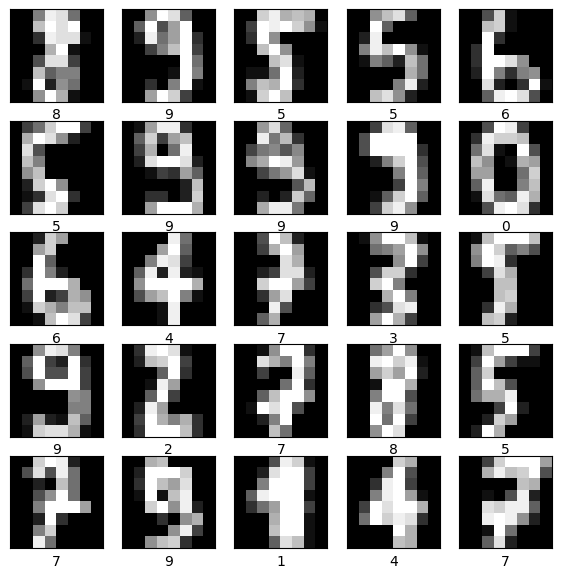

In [7]:
visualise()

# Building out the Neural Net

Since this purpose of this project is to show the "under the hood" of neural nets and backpropagation, we are going to use a fairly simple structure here:

1. Linear Layer
2. ReLU Layer
3. Linear Layer
4. Softmax Layer

We do not even need an Input or Flatten Layer, as the samples are already flattened

## Initializing our Neural Net

In [8]:
n_hidden = 10  # number of neurons on the hidden layers
T = x.shape[1]  # time (pixels in our case). The dimensions for images are B, T, C
n_classes = len(np.unique(y))  # number of classes (10 in our case)

Here we initialize our trainable parameters, namely the weights and biases of our linear layers.

We draw from a normal (Gaussian) distribution.

Our inputs are of shape `(B, T)`, therefore the first weight matrix `w1` must have a shape of `(T, n_hidden)` where `n_hidden` are the number of hidden neurons above, in order for the matrix multiplication to work out. The biases `b1` are a 1D vector of size `(n_hidden)`, one for every neuron, therefore everything works out just fine.

In the second layer we take as input a matrix of shape `(B, n_hidden)`, so the shape of the weights `w2` should be `(n_hidden, n_classes)` so that the information is squashed down to `(B, n_classes)`, so logits for every pixel in every batch. The shape of `b2` which is `n_classes` works out just fine as well

One thing that is worth noting is the fact that we multiply our weights and biases with `0.1`. The reason for this is to flatten out the logits at the beginning, so that our network is not confidently wrong from the start. This would give a very high loss at the beginning, which would mean that our training time is less efficient.

Honestly said, the number `0.1` is arbitrary here. Ideally we would do Kaiming Initialization, but such advanced topics are outside the scope of this notebook and would complicate it too much.

In [9]:
# First Linear Layer
w1 = np.random.normal(size=(T, n_hidden)) * 0.1 # weights
b1 = np.random.normal(size=(n_hidden, )) * 0.1  # biases

# Second Linear Layer
w2 = np.random.normal(size=(n_hidden, n_classes)) * 0.1  # weights
b2 = np.random.normal(size=(n_classes, )) * 0.1  # biases

## Training

### Functions used during training loop

#### Forward pass

Nothing special, just going through the structure defined above. The operations are done as step-by-step as possible so as to make the understanding of backpropagation later on easier

In [10]:
def forward(X, train=False):  # forward pass according to the structure we defined above

    # -------First Linear Layer-------
    linear1 = X @ w1 + b1  # matrix multiply and add biases

    # -------ReLU Layer-------
    # apply the ReLu function (max(0, n)) to the first linear layer
    relu = np.maximum(linear1, np.zeros_like(linear1))

    # -------Second Linear Layer-------
    logits = relu @ w2 + b2  # matrix multiply and add biases

    # -------Softmax Layer-------
    exps = np.exp(logits)  # exponentiate the logits to get numbers above 0
    sums = np.sum(exps, axis=1, keepdims=True)  # sum of these exponents
    # divide the exponentials with the sum to get probability-like values
    probs = exps / sums

    if train:  # if training return all so that we calculate gradients
        return probs, sums, exps, logits, relu, linear1
    else:  # else return only the probabilitites
        return probs

#### Prediction

In [11]:
def predict(X):  # function that predicts the target class based on our Xs
    probs = forward(X)  # forward pass to get probabilites
    return probs.argmax(axis=1)  # return the class with the maximal probability

#### Accuracy check

In [12]:
def accuracy(X, Y):  # function that checks the accuracy for a given batch
    preds = predict(X)  # predict the classes of our X
    # find how many were found correctlly then mean to get average accuracy
    return (preds == Y).mean()

#### Loss

The loss we are going to use for our exercise is negative log likelihood, otherwise known as cross-entropy loss

In [13]:
def cross_entropy(X, Y, train):
    r = forward(X, train)  # what the forward pass returns
    probs = r[0] if train else r  # get the probabilities for our X
    n = probs.shape[0]  # number of samples
    logprobs = np.log(probs)
    # at each sample get the loss according to the target for that sample
    loss = -logprobs[range(n), Y].mean()  # get the mean negative log likelihood
    if train:
        return loss, logprobs, n, r
    else:
        return loss

#### Backprop

The function `train`, what it essentially does, is that it first makes the forward pass and finds the loss for the batch. Then it finds the derivatives starting from the loss and adjusts the weights and biases `w1`, `b1`, `w2` and `b2`

You can find explanations for gradient calculations as comments next to them

In [14]:
def train(X, Y, lr):  # backpropagate through the batch

    #------- a) Get the loss and intermediate values -------
    loss, logprobs, n, (probs, sums, exps, logits, relu, linear1) = cross_entropy(X, Y, True)  # the loss we get with this batch

    #------- b) Find the gradients -------

    # Gradients through Cross Entropy
    dlogprobs = np.zeros_like(logprobs)  # all are 0 initially
    dlogprobs[range(n), Y] = -1 / n  # the ones calculated in the mean
    dprobs = dlogprobs * (1 / probs)  # apply the derivative of the log

    # Gradients through Softmax Layer
    dexps = dprobs / sums  # 1 / sums since it is divided by it, chain rule with dprobs
    # apply derivation rule then add across row
    dsums = np.sum((dprobs * -exps * sums**-2), axis=1, keepdims=True)
    dexps += 1 * dsums  # gradient 1 in contribute to sum, apply chain rule
    dlogits = dexps * exps  # local derivative is the exponential function,

    # Gradients through the Second Linear Layer
    global w1, w2, b1, b2  # tell the function we want the variables from above

    # a simple trick is to just multiply the shapes so that everything works out
    drelu = dlogits @ w2.T
    dw2 = relu.T @ dlogits
    db2 = dlogits.sum(0)

    # Gradients through the ReLU layer
    # Just apply chain rule to numbers fr
    dlinear1 = drelu * (linear1 > 0).astype("float64")

    # Gradients through the first linear layer
    # use the same trick as above
    dw1 = X.T @ dlinear1
    db1 = dlinear1.sum(0)

    # ------- 3) Change the parameters -------
    # negative of the learning rate times the gradients
    w1 += (-lr * dw1)
    b1 += (-lr * db1)
    w2 += (-lr * dw2)
    b2 += (-lr * db2)

### Training Loop

The hyperparameters below are fairly arbitrary and I've found out that they work well. However, feel free to change and play around with them

In [15]:
# hyperparameters
B = 16 # batch size
lr = 0.01  # learning rate
epochs = 140 # number of epochs we train for

In [16]:
# statistics to plot later
train_accs, val_accs, train_losses, val_losses = [], [], [], []

In [17]:
print("                           Acc | Loss")
for i in range(epochs):  # number of epochs we will train for
    # take a look at every batch
    for j in range(0, xtrain.shape[0], B):
        # define xb and yb, x-batch and y-batch
        xb = xtrain[j:] if xtrain.shape[0] - j < B else xtrain[j:j+B]
        yb = ytrain[j:] if ytrain.shape[0] - j < B else ytrain[j:j+B]

        # do the forward and backward passes
        train(xb, yb, lr)

    # keep track of the statistics
    train_acc, val_acc = accuracy(xtrain, ytrain), accuracy(xval, yval)
    train_loss = cross_entropy(xtrain, ytrain, False)
    val_loss = cross_entropy(xval, yval, False)

    # append stats to outer arrays
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if (i+1) % 10 == 0:
        print(f"{i+1:03}) train: {train_acc*100:05.2f}% val: {val_acc*100:.2f}% | train: {train_loss:.4f} val: {val_loss:.4f} ")

                           Acc | Loss
010) train: 94.99% val: 92.82% | train: 0.1784 val: 0.2530 
020) train: 97.01% val: 93.92% | train: 0.0998 val: 0.1781 
030) train: 98.05% val: 94.48% | train: 0.0697 val: 0.1574 
040) train: 98.54% val: 94.48% | train: 0.0509 val: 0.1603 
050) train: 99.16% val: 95.03% | train: 0.0390 val: 0.1726 
060) train: 99.16% val: 95.03% | train: 0.0309 val: 0.1875 
070) train: 99.44% val: 95.58% | train: 0.0258 val: 0.2017 
080) train: 99.51% val: 95.03% | train: 0.0221 val: 0.2140 
090) train: 99.58% val: 94.48% | train: 0.0186 val: 0.2250 
100) train: 99.65% val: 94.48% | train: 0.0162 val: 0.2386 
110) train: 99.72% val: 93.92% | train: 0.0137 val: 0.2465 
120) train: 99.79% val: 93.92% | train: 0.0118 val: 0.2553 
130) train: 99.86% val: 93.92% | train: 0.0102 val: 0.2606 
140) train: 99.86% val: 93.37% | train: 0.0091 val: 0.2651 


# Testing and Evaluating

## Plotting the accuracy and loss curves

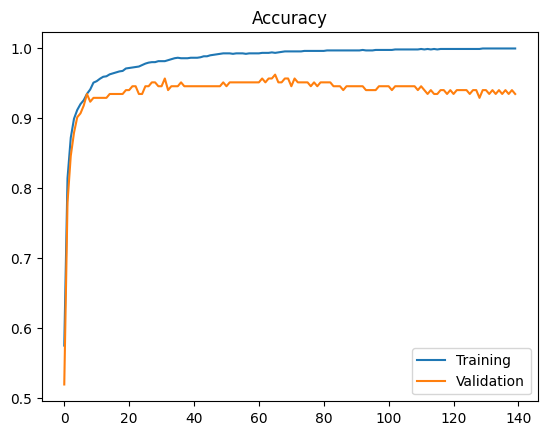

In [18]:
plt.plot(train_accs, label="Training")
plt.plot(val_accs, label="Validation")
plt.title("Accuracy")
plt.legend()
plt.show();

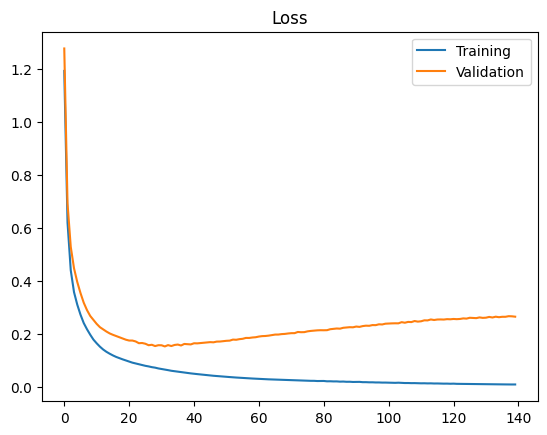

In [19]:
plt.plot(train_losses, label="Training")
plt.plot(val_losses, label="Validation")
plt.title("Loss")
plt.legend()
plt.show();

As we can see in the graphs above, we still have somewhat of a problem with overfitting. Anyways, the results are pretty good for the simple scope of our exercise

## Performance on the test set

As we can see, the statistics are pretty good. Can you push them further?

In [20]:
test_acc = accuracy(xtest, ytest)
test_loss = cross_entropy(xtest, ytest, train=False)
test_acc, test_loss

(0.9553072625698324, 0.12473613566102838)

### Comparing with train and validation sets

Let's find out the statistics for the train and validation tests too and plot them out against the test stats

In [21]:
train_acc = accuracy(xtrain, ytrain)
train_loss = cross_entropy(xtrain, ytrain, train=False)
train_acc, train_loss

(0.9986082115518441, 0.009099405127575972)

In [22]:
val_acc = accuracy(xval, yval)
val_loss = cross_entropy(xval, yval, train=False)
val_acc, val_loss

(0.9337016574585635, 0.2650912718638565)

In [23]:
bins = ["Training set", "Validation set", "Testing set"]

In [24]:
accs = [train_acc, val_acc, test_acc]
losses = [train_loss, val_loss, test_loss]

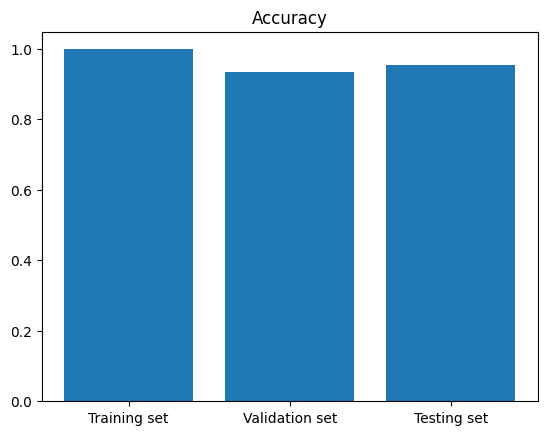

In [25]:
plt.bar(bins, accs)
plt.title("Accuracy")
plt.show();

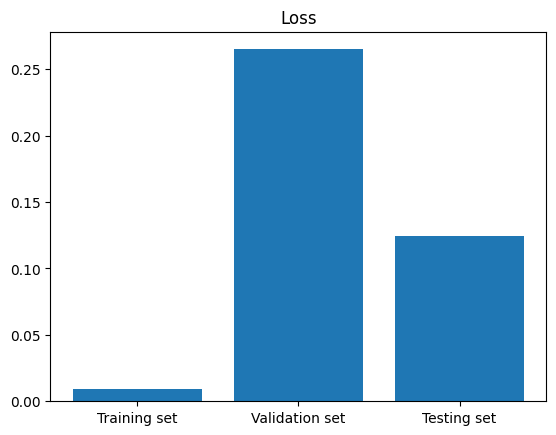

In [26]:
plt.bar(bins, losses)
plt.title("Loss")
plt.show();

## Vizualising results

Let's visualise our results using the `visualise()` function that we built out earlier. Here I am visualising 100 samples, so as to confirm the test accuracy we found out earlier

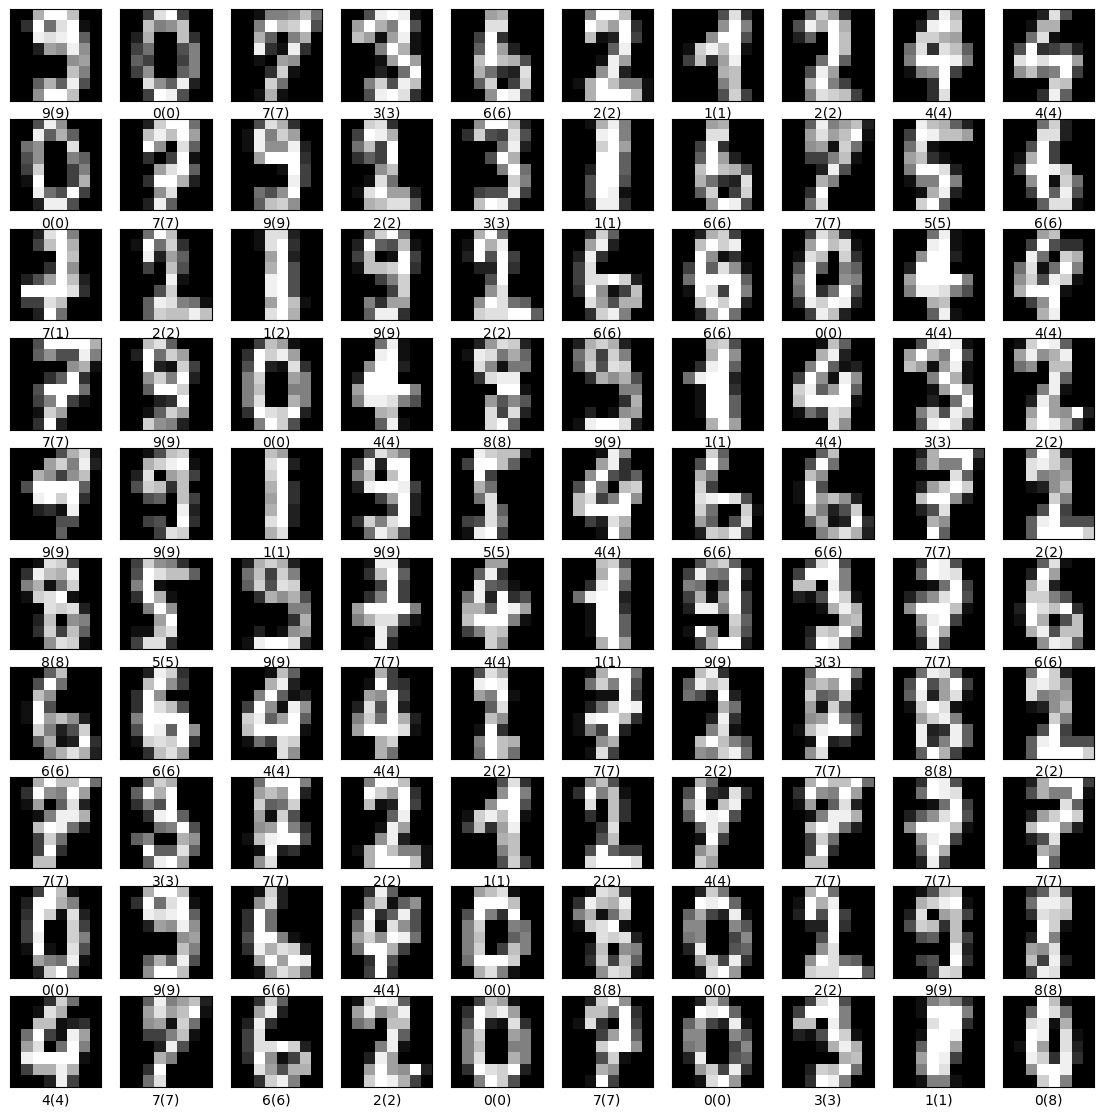

In [27]:
visualise(nrows=10, ncols=10, pred=True, split="test", figsize=(14, 14))